In [1]:
import numpy as np
import torch
import torchani
import os
import math
import pickle

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def load_pickle():
    f = open('model_config', 'rb')     
    cfg = pickle.load(f)
    f.close()
    return cfg

In [3]:
cfg = load_pickle()

In [4]:
device = 'cpu'

## Importing Model Definition

In [5]:
from Model_Hyperparameters import get_aev_params, get_complete_network

In [6]:
energy_shifter, aev_computer = get_aev_params(device)
model, nn = get_complete_network(aev_computer, device)

In [7]:
latest_checkpoint = 'latest.pt'

In [8]:
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    nn.load_state_dict(checkpoint['nn'])

## Importing testing data

In [9]:
init, last = cfg['testing']
print(init, last)

105000 326250


In [10]:
from_path = "{}/{}/{}".format(cfg['share_path'],cfg['name'], "testing.h5")
to_path = "{}/{}/".format(cfg['scratch_path'], cfg['name'])
print(from_path, to_path)
os.system('mkdir -p {}'.format(to_path))
os.system('rsync -aPs ada:{} {}'.format(from_path, to_path))

/share1/shaunak/ML4NS/Napthalene/testing.h5 /scratch/shaunak/ML4NS/Napthalene/


0

In [11]:
print("{}/{}".format(to_path, "testing.h5"))

/scratch/shaunak/ML4NS/Napthalene//testing.h5


In [12]:
data = torchani.data.load("{}/{}".format(to_path, "testing.h5"))

## Loading saved model parameters

In [13]:
species_order = ['H', 'C', 'N', 'O']
energy_shifter = torchani.utils.EnergyShifter(None)

In [14]:
p = data.subtract_self_energies(energy_shifter, species_order).species_to_indices(species_order)

In [15]:
batch_size = 5000
print(batch_size)

5000


In [16]:
h = p.collate(batch_size).cache()
iterable_test_data = iter(h)

In [17]:
y_hat = np.array([])
y = np.array([])

In [18]:
while True:
    try:
        g = next(iterable_test_data)
    except:
        break
    species = g['species']
    coordinates = g['coordinates'].float()
    true_energies = g['energies'].float()
    _, predicted_energies = model((species, coordinates))
    y_hat_batch = true_energies.cpu().detach().numpy()
    y_batch = predicted_energies.cpu().detach().numpy()
    y_hat = np.append(y_hat, y_hat_batch)
    y = np.append(y, y_batch)

In [19]:
print(y_hat.shape, y.shape)

(221250,) (221250,)


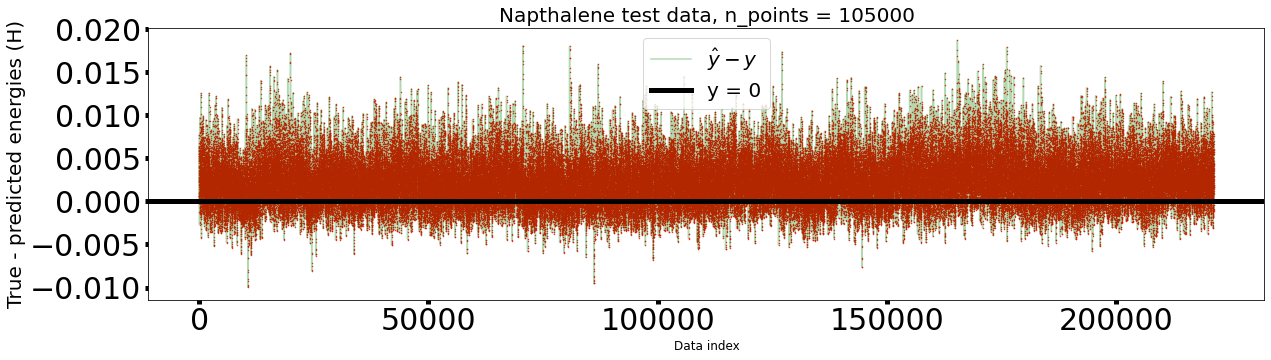

In [20]:
fig = plt.figure(figsize = (20, 5))
diff = y_hat - y
x = np.arange(diff.shape[0])
plt.plot(diff, alpha = 0.3, color = 'green', label = r'$\hat{y} - y$')
plt.scatter(x, diff, color='red', s = 0.2)
plt.axhline(y = 0, color='black', linewidth = 5, label = "y = 0")
plt.title("{} test data, n_points = {}".format(cfg['name'], cfg['batches'][-1]), fontsize = 20)
plt.xlabel('Data index', fontsize = 12)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
ax = plt.gca()
ax.xaxis.set_tick_params(width = 5)
ax.yaxis.set_tick_params(width = 5)
plt.ylabel('True - predicted energies (H)', fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig('Loss data')

In [21]:
mae = np.mean(np.abs(diff))
rmse = np.mean(diff * diff)
from torchani.units import hartree2kcalmol, hartree2ev

m, r = hartree2kcalmol(mae), hartree2kcalmol(rmse)
mev, rev = hartree2ev(mae), hartree2ev(rmse)

In [22]:
print(y.shape[0], m, r, mev, rev)

221250 1.7763069595029337 0.008130593820348437 0.07702795955123205 0.00035257591519911077
